In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"using device: {device}")

using device: cuda


## 1. Generate data
* set up weight and bias
* generate input X tensor as (50, 1) shape. Each row is an example
* generate output y tensor as (50, 1) shape

In [4]:
# create weight and bias
weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
# define plot_predictions function to visualize the train and test data points
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

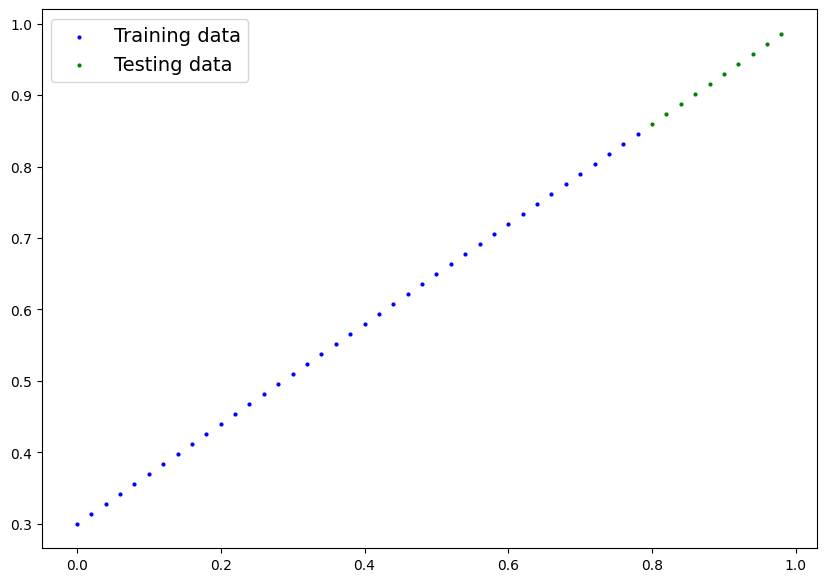

In [7]:
plot_predictions(X_train, y_train, X_test, y_test)

## 2. Building a PyTorch linear model
### 2.1 build a linear regression model using nn.Linear()

In [22]:
# build LinearModel from nn.Module base class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

    # use linear layer to create weight and bias parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # define forward computing
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model = LinearRegressionModel()
model, model.state_dict()      

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### 2.2. put model on GPU

In [23]:
# check the current device of the model
next(model.parameters()).device

device(type='cpu')

In [24]:
# put mode on GPU
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 3. Train mode
* define loss function
* define optimizer
* set up work flow with 100 epochs 
  + each epoch is one pass of training data
* embed model evaluation for every 10 epochs  

In [25]:
# create loss funtion
loss_fun = nn.L1Loss()

# create optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr= 0.01)

In [26]:

# put data on GPU
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [28]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):

  # set mode in training mode
  model.train()

  # get predictions
  y_preds = model(X_train)

  # calculate loss
  loss = loss_fun(y_preds, y_train)

  # set gradient as zero
  optimizer.zero_grad()

  # calculate gradient by back propagation
  loss.backward()

  # update linear model parameters by optimizer
  optimizer.step()

  ## test for evaluation
  model.eval()

  # evaluate prediction
  with torch.inference_mode():
    y_test_preds = model(X_test)
    test_loss = loss_fun(y_test_preds, y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | train loss: {loss} | test loss: {test_loss}")

Epoch: 0 | train loss: 0.5551779866218567 | test loss: 0.5739762187004089
Epoch: 10 | train loss: 0.439968079328537 | test loss: 0.4392664134502411
Epoch: 20 | train loss: 0.3247582018375397 | test loss: 0.30455657839775085
Epoch: 30 | train loss: 0.20954833924770355 | test loss: 0.16984669864177704
Epoch: 40 | train loss: 0.09433845430612564 | test loss: 0.03513690456748009
Epoch: 50 | train loss: 0.023886388167738914 | test loss: 0.04784907028079033
Epoch: 60 | train loss: 0.019956795498728752 | test loss: 0.045803118497133255
Epoch: 70 | train loss: 0.016517987474799156 | test loss: 0.037530567497015
Epoch: 80 | train loss: 0.013089174404740334 | test loss: 0.02994490973651409
Epoch: 90 | train loss: 0.009653178043663502 | test loss: 0.02167237363755703


In [29]:
from pprint import pprint
print("The model learned the follwoing values for weights and bias:")
pprint(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")


The model learned the follwoing values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 4. Making predictions

In [30]:
# set model to evaluation mode
model.eval()

# make prediction on test data
with torch.inference_mode():
  test_preds = model(X_test)

test_preds  


tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]], device='cuda:0')

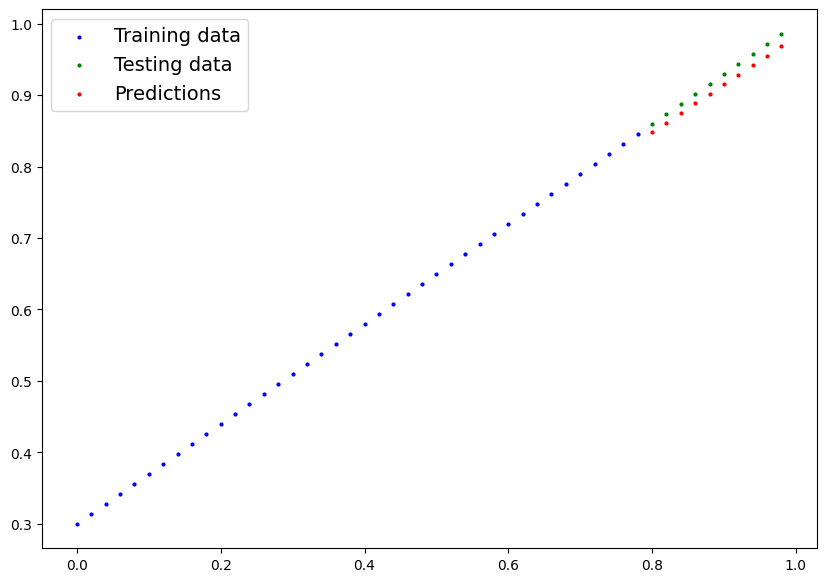

In [31]:
# plot the predictions and true values of y_test
plot_predictions(predictions=test_preds.cpu())

### 5. Save and load a mode by state_dict

In [32]:
# create folder to save parameter file
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "pythorch_workflow_gpu.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the mode state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


Saving model to: models/pythorch_workflow_gpu.pth


In [34]:
# load model using state_dict from the saved file
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model.to(device)
print(f"Loaded model:\n{loaded_model}")
print(f"Loaded on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Loaded on device:
cuda:0


In [35]:
# do inference
loaded_model.eval()

with torch.inference_mode():
  pred_test_loaded_model = loaded_model(X_test)

test_preds == pred_test_loaded_model  



tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')